<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_3_SHAP_vision_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:24/03/2023)-

B. Цель данного блокнота

Целью этого блокнота является использование SHAP на предобученной модели для понимания области наблюдения для каждого класса.

C. План реализации

1. Импортировать данные и модель
2. Реализовать расчет shap values
3. Реализовать построение графика для shap values и одного спектра

NOTES
1. Импортированы данные и модель
2. Получены данные shap values
3. Реализована функция визуализации

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [2]:
!git clone https://github.com/Lamblador/IR_expert_system.git

fatal: destination path 'IR_expert_system' already exists and is not an empty directory.


In [3]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
!pip install shap
clear_output()

In [4]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import shap

# Импорт табличных данных

In [5]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")

Импорт данных и обработка спектров

In [6]:
from jcamp import jcamp_readfile
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# Create an empty list to store spectra data
ref_spectra = []
# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])    
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass 

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"
            
            #normalize
           
        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]: 
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)

File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116402-07-4
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/93-03-8
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/91-13-4
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1570-64-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1975-52-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/23063-36-7
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/101-80-4
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/607-04-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/2432-11-3
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1420-07-1
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/19829-72-2
File can't b

In [7]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
21386-21-0,"[382.0, 383.0, 384.0, 385.0, 386.0, 387.0, 388...","[0.2712, 0.27109998, 0.27100003, 0.2709, 0.270...",382,3798,3417
5862-40-8,"[383.0, 384.0, 385.0, 386.0, 387.0, 388.0, 389...","[0.8265, 0.8204, 0.8153, 0.81159997, 0.8086999...",383,3800,3418
87384-00-7,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[0.00551, 0.00559, 0.00559, 0.00546, 0.00538, ...",549.863,3999.53,1789
627-97-4,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002775, 0.0001825, 0.0001275, 0.0001825, 0...",550,3846,825
18967-35-6,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.01477, 0.01471, 0.01458, 0.01446, 0.01476, ...",549.759,4000.7,1790
...,...,...,...,...,...
29504-89-0,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.003238, 0.003138, 0.002878, 0.002968, 0.003...",549.759,4000.7,1790
335-99-9,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.008407684, 0.008407684, 0.009223964, 0.0082...",450,3966,880
131-91-9,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.00068, 0.0002346, 0.0, 9.52e-05, 5.78e-05, ...",550,3846,825
17614-74-3,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.002531, 0.002321, 0.002131, 0.001911, 0.001...",549.759,4000.7,1790


In [8]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue 

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue 


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)
  
  return x_new, y_new



In [9]:
x_list, y_list = [], []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=1
      x_list.append(np.nan)
      y_list.append(np.nan) 
print(f'Found {errors} errors')

100%|██████████| 14346/14346 [01:10<00:00, 203.29it/s]

Found 38 errors


In [10]:
x_serie = pd.Series(x_list)
y_serie = pd.Series(y_list)

In [11]:
df = pd.DataFrame(x_serie, columns = ['x1'])
df['y1'] = y_serie

In [12]:
dataset_df = dataset_df.reset_index()
dataset_df1 = dataset_df.join(df, lsuffix='x')
dataset_df1[['x', 'x1', 'y', 'y1']]

,x,x1,y,y1
0,"[382.0, 383.0, 384.0, 385.0, 386.0, 387.0, 388...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.2712, 0.27109998, 0.27100003, 0.2709, 0.270...","[0.19010001420974731, 0.18900001049041748, 0.1..."
1,"[383.0, 384.0, 385.0, 386.0, 387.0, 388.0, 389...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.8265, 0.8204, 0.8153, 0.81159997, 0.8086999...","[0.11009997129440308, 0.10860002040863037, 0.1..."
2,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00551, 0.00559, 0.00559, 0.00546, 0.00538, ...","[0.005510000046342611, 0.005510000046342611, 0..."
3,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002775, 0.0001825, 0.0001275, 0.0001825, 0...","[0.00027749998844228685, 0.0002774999884422868..."
4,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01477, 0.01471, 0.01458, 0.01446, 0.01476, ...","[0.014770000241696835, 0.014770000241696835, 0..."
...,...,...,...,...
14341,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.003238, 0.003138, 0.002878, 0.002968, 0.003...","[0.003237999975681305, 0.003237999975681305, 0..."
14342,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.008407684, 0.008407684, 0.009223964, 0.0082...","[0.01514199422672391, 0.017468392848968506, 0...."
14343,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00068, 0.0002346, 0.0, 9.52e-05, 5.78e-05, ...","[0.0006799999973736703, 0.0006799999973736703,..."
14344,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.002531, 0.002321, 0.002131, 0.001911, 0.001...","[0.0025309999473392963, 0.0025309999473392963,..."


In [13]:
dataset_df1 = dataset_df1.set_index('cas registry no')

In [14]:
dataset_df_labeled = labels_df.join(dataset_df1)

In [15]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1']]
#dataset_df_labeled1

In [16]:
spectra_x =dataset_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
#spectra_x_t

# Создание класса Dataset

Вивлеты - преобразование для детектирования пиков.

In [17]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-2]
        self.spectra_y = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))      
        spectra = torch.cat((spectra_x, spectra_y))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [18]:
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1)

In [19]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [20]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [21]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [22]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6827464492814522, 'methyl': 0.6216488780569795, 'alkene': 0.13555760988318347, 'alkyne': 0.019497436759391546, 'alcohols': 0.21867383813765862, 'amines': 0.13085133204470964, 'nitriles': 0.03815446676191277, 'aromatics': 0.5847550214303723, 'alkyl halides': 0.2593495251701824, 'esters': 0.11648037650222708, 'ketones': 0.09420959744516345, 'aldehydes': 0.020589965543322968, 'carboxylic acids': 0.06025716446760232, 'ether': 0.25018909152029584, 'acyl halides': 0.00966467770400874, 'amides': 0.07101437095554249, 'nitro': 0.05723170014286915}


In [23]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6216, 0.1356, 0.0195, 0.2187, 0.1309, 0.0382, 0.5848, 0.2593,
        0.1165, 0.0942, 0.0206, 0.0603, 0.2502, 0.0097, 0.0710, 0.0572],
       dtype=torch.float64)


In [24]:
#Модифицирование весов для каждого класс:
level = 0.3
grain = 0.15
lg = level/grain
print(lg)
#Классы меньше grain процентов - увеличиваются в level/20 раза 
#Классы меньше 10 процентов - увеличиваются в level/10 раз 
#Классы меньше 5 процентов - увеличиваются в level/5 раз
#Классы меньше 1 процента - увеличиваются в level раз
weight_for_every_class_modified = []
for i in weight_for_every_class:
  if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
  elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
  elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
  elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
  else: weight_for_every_class_modified.append(i)
weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
print(weight_for_every_class)
print(weight_for_every_class_modified)
print(weight_for_every_class_modified.size())

2.0
tensor([0.6827, 0.6216, 0.1356, 0.0195, 0.2187, 0.1309, 0.0382, 0.5848, 0.2593,
        0.1165, 0.0942, 0.0206, 0.0603, 0.2502, 0.0097, 0.0710, 0.0572],
       dtype=torch.float64)
tensor([6.8275e-01, 6.2165e-01, 1.6945e-02, 2.4372e-03, 2.1867e-01, 1.6356e-02,
        9.5386e-03, 5.8476e-01, 2.5935e-01, 1.4560e-02, 1.1776e-02, 2.5737e-03,
        1.5064e-02, 2.5019e-01, 6.0404e-04, 1.7754e-02, 1.4308e-02])
torch.Size([17])


In [25]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
#labels1

In [26]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0572, 0.0572, 0.0572,  ..., 0.2593, 0.0572, 0.1309],
       dtype=torch.float64)


In [27]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [28]:
weights_train

tensor([0.0572, 0.0572, 0.0572,  ..., 0.2593, 0.0603, 0.0603],
       dtype=torch.float64)

In [29]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [30]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [31]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

1747.4449953777091


In [32]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [33]:
weights_train

tensor([3.2752e-05, 3.2752e-05, 3.2752e-05,  ..., 1.4842e-04, 3.4483e-05,
        3.4483e-05], dtype=torch.float64)

In [34]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [35]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [36]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())
    


@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    model.eval()
    for ir_spec, labels in test_loader:
      
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        #total_count = (labels.to('cpu') == 1.0).sum().item()
        #total += total_count
        #print(pred)
        #print(labels)
        #tolerance = (1.0-(1.0/(epoch+1)))-0.2
        score= get_correct_count_lraps(pred, labels)
        #print(correct)
    #model.to('cpu')
    return score, loss

In [37]:
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        global device
        print("Using device:", device)
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )  
        self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 100, gamma=0.1, last_epoch=- 1, verbose=True)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight = weight_for_every_class.to(device))  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)
        
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                
                score = self.process_batch(ir_spec, labels)
                #total_count = (labels.cpu() == 1.0).sum().item()
                #total += total_count
            self.sheduler.step()
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])
          

    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()
        
        return get_correct_count_lraps(out.cpu(), labels)

Показывать loss на тексте, чтобы было понятно переобучение.

Код для визуализации из прошлых заданий, можно заменить его собственым.

In [38]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

## Код модели v0.4.0 - добавленеи к 0.3.0 макспулов для уменьшения количества параметров.

In [39]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet2(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet2, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        # self.layer2 = nn.Sequential(
        #     BasicBlock(hidden_size, downsample = False), #[2,1800]
        #     BasicBlock(hidden_size),
        #     BasicBlock(hidden_size))
        self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        # self.layer4 = nn.Sequential(
        #     BasicBlock(hidden_size*2, downsample = False), 
        #     BasicBlock(hidden_size*2),
        #     BasicBlock(hidden_size*2))
        self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        # self.layer6 = nn.Sequential(
        #     BasicBlock(hidden_size*4, downsample = False), 
        #     BasicBlock(hidden_size*4),
        #     BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        # self.layer8 = nn.Sequential(
        #     BasicBlock(hidden_size*8, downsample = False), #[2,225]
        #     BasicBlock(hidden_size*8),
        #     BasicBlock(hidden_size*8))
        self.adppool = nn.AdaptiveMaxPool1d(28)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*28, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        #self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        batch = self.max1(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        batch = self.max2(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        
        #scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

## Импорт модели

Импортируем модель v0.4.1.30

In [40]:
model = IrResnet2(30)
model.load_state_dict(torch.load('/content/IR_expert_system/models/v0.4.1.30/model_params'))
model.eval()

IrResnet2(
  (conv1): Conv1d(2, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(


In [41]:
from sklearn.metrics import classification_report
import gc
def get_statistic(model, device, val_dataloader, tolerance = 0.9):
  y_true = []
  y_pred = []
  labels = []
  model.eval()
  for data, label in val_dataloader:
    out = model.to(device)(data.to(device))
    y_true.append(label)
    y_pred.append(out.cpu().detach().numpy())
    out.cpu()
  y_pred[0][y_pred[0]<tolerance]=0
  y_pred[0][y_pred[0]>=tolerance]=1
  model.to('cpu')
  torch.cuda.empty_cache()
  gc.collect()
  return classification_report(y_true[0], y_pred[0], target_names = classes)


In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

9

In [43]:
cr = get_statistic(model, device, dataloader_ir_val, tolerance = 0.5)
print(cr)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.


                  precision    recall  f1-score   support

          alkane       0.97      0.94      0.96       803
          methyl       0.98      0.93      0.95       726
          alkene       1.00      0.32      0.48       172
          alkyne       1.00      0.09      0.17        22
        alcohols       1.00      0.69      0.82       266
          amines       0.97      0.43      0.60       148
        nitriles       1.00      0.03      0.06        32
       aromatics       0.98      0.94      0.96       695
   alkyl halides       0.96      0.42      0.58       297
          esters       0.98      0.46      0.63       134
         ketones       0.88      0.12      0.22       121
       aldehydes       1.00      0.43      0.61        23
carboxylic acids       1.00      0.17      0.29        78
           ether       0.98      0.64      0.77       303
    acyl halides       0.00      0.00      0.00         9
          amides       1.00      0.06      0.11        86
           ni

# Расчет SHAP values

In [44]:
#Создаём тестовый объект
batch = next(iter(dataloader_ir_val))
images, _ = batch

background = images[:100]
test_images = images[100:103]
test_images

tensor([[[5.0000e+02, 5.0200e+02, 5.0400e+02,  ..., 4.0940e+03,
          4.0960e+03, 4.0980e+03],
         [4.9000e-04, 4.9000e-04, 4.9000e-04,  ..., 2.6600e-04,
          2.6600e-04, 2.6600e-04]],

        [[5.0000e+02, 5.0200e+02, 5.0400e+02,  ..., 4.0940e+03,
          4.0960e+03, 4.0980e+03],
         [3.0040e-04, 3.0646e-04, 3.3249e-04,  ..., 2.7230e-04,
          2.7230e-04, 2.7230e-04]],

        [[5.0000e+02, 5.0200e+02, 5.0400e+02,  ..., 4.0940e+03,
          4.0960e+03, 4.0980e+03],
         [3.2380e-02, 3.2380e-02, 3.2380e-02,  ..., 1.6300e-03,
          1.6300e-03, 1.6300e-03]]])

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [45]:
#Создаём объект explainer
explainer = shap.DeepExplainer(model, background)

In [46]:

shap_values = explainer.shap_values(test_images)
clear_output()

In [47]:
torch.Tensor(shap_values).shape

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


torch.Size([17, 3, 2, 1800])

In [48]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
x, y = test_images[0]
x, y = np.array(x), np.array(y)

In [49]:
shap_values1 = np.array(shap_values)
shap_values2 = np.swapaxes(shap_values1, 0, 1)
shap_values2.shape

(3, 17, 2, 1800)

In [50]:
shap_values2[0][0][1]

array([-6.17725746e-05, -5.78255349e-05, -9.59064892e-06, ...,
        2.90645083e-04,  1.57273171e-04,  3.77791657e-05])

In [51]:
dydx = shap_values2[0][0][1]
dydx.min()
dydx.max()

0.2538658082485199

In [53]:
# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
print(points.shape)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
segments.shape


(1800, 1, 2)


(1799, 2, 2)

# Функция визуализации

In [216]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_shap_values(model, dataloader, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(100+num_test_samples):
     background = images[:100]
     test_images = images[100:(100+num_test_samples)]
     test_labels = labels[100:(100+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  
  explainer = shap.DeepExplainer(model, background)
  shap_values = explainer.shap_values(test_images)
  shap_values1 = np.array(shap_values)
  shap_values2 = np.swapaxes(shap_values1, 0, 1)
  shap_plus_img = {}
  shap_plus_img['image'] = test_images
  shap_plus_img['shap_values'] = shap_values2
  shap_plus_img['labels'] = test_labels
  clear_output()
  return shap_plus_img

def view_all_classes_shap(shap_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = shap_plus_img['image'][num]
  shap_values = shap_plus_img['shap_values'][num]
  test_labels = shap_plus_img['labels'][num]
  x, y = test_spectra
  x, y = np.array(x), np.array(y)
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if mode == 'continuous':
   fig, axs = plt.subplots(4, 5, figsize=(20, 12))
   for i in range(4):
      for j in range(5):
        if i+j <= 15:
          dydx = shap_values[i][1]
     
          # Create a continuous norm to map from data points to colors
          norm = plt.Normalize(dydx.min(), dydx.max())
          lc = LineCollection(segments, cmap='hot', norm=norm)
          # Set the values used for colormapping
          lc.set_array(dydx)
          lc.set_linewidth(2)
          line = axs[i][j].add_collection(lc)
          fig.colorbar(line, ax=axs[i][j])
          axs[i][j].set_xlim(x.min(), x.max())
          ly=y.max()
          axs[i][j].set_ylim(-0.01*ly, ly)
          label = list(np.array(test_labels, dtype = np.int32))[i+j]
          title = inx2cls[i+j]+' '+str(label)
          axs[i][j].set_title(title)
        else: break
   fig.set_figheight(12)
   fig.set_figwidth(20)
   
  elif mode == 'segments':
    fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(20, 12))
    for i in range(4):
      for j in range(5):
        if i+j <= 15:
          dydx = shap_values[i+j][1]
      
          # Use a boundary norm instead
          cmap = ListedColormap(['r', 'g', 'y', 'b'])
          norm = BoundaryNorm([dydx.min(), dydx.max()/3, dydx.max()*2/3, dydx.max()], cmap.N)
          lc = LineCollection(segments, cmap=cmap, norm=norm)
          lc.set_array(dydx)
          lc.set_linewidth(2)
          line = axs[i][j].add_collection(lc)
          fig.colorbar(line, ax=axs[i][j])
          axs[i][j].set_xlim(x.min(), x.max())
          ly=y.max()
          axs[i][j].set_ylim(-0.01*ly, ly)
          label = list(np.array(test_labels, dtype = np.int32))[i+j]
          title = inx2cls[i+j]+' '+str(label)
          axs[i][j].set_title(title)
        else: break
    fig.set_figheight(12)
    fig.set_figwidth(20)
  
  plt.show()



In [194]:
shap_values = calc_shap_values(model, dataloader_ir_test, num_test_samples = 3)

In [209]:
shap_values['image'][0]

tensor([[5.0000e+02, 5.0200e+02, 5.0400e+02,  ..., 4.0940e+03, 4.0960e+03,
         4.0980e+03],
        [2.6868e-03, 2.6868e-03, 2.6868e-03,  ..., 1.4760e-04, 1.4760e-04,
         1.4760e-04]])

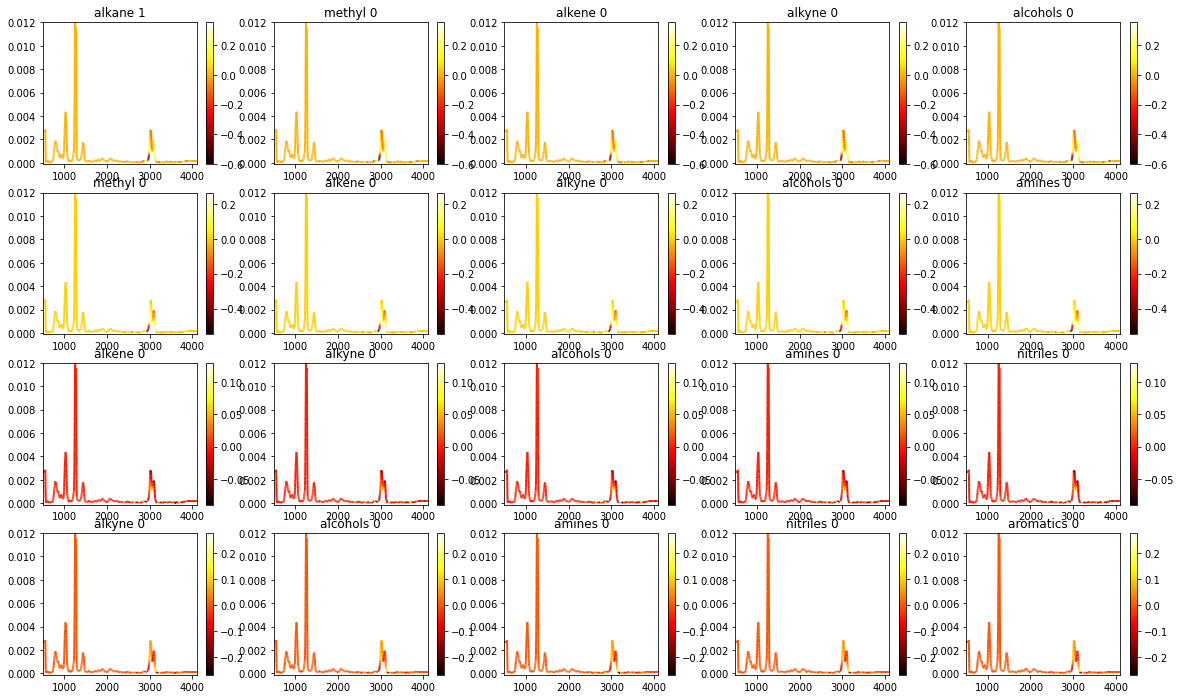

In [217]:
view_all_classes_shap(shap_values, inx2cls, 0,  mode = 'continuous')

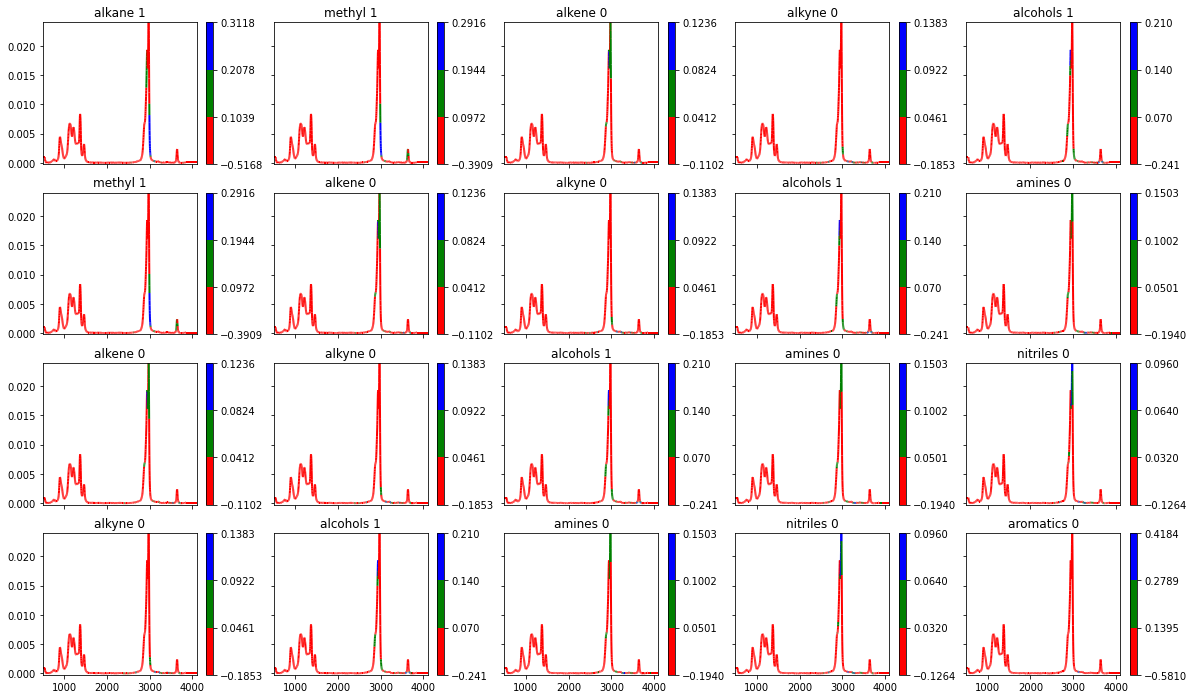

In [218]:
view_all_classes_shap(shap_values, inx2cls, 1,  mode = 'segments')

# Конец

## Сохранение модели

In [ ]:
#torch.save(model2.state_dict(), f= '/content/IR_expert_system/models/v0.3.11/model_params')

In [ ]:
#torch.save(trainer.optimizer.state_dict(), f= '/content/IR_expert_system/models/v0.3.11/optim_params')